# Documentation

**Author:** Anirudh  
**Date:** 30/04/2025  

### Details:
- **Modeling:** Using Linear mixed models now to study the longitudinal changes with respective to Diagnosis (Given BL_DX how cognitive changes overtime with sleep variables)
    - Two types of models to be made : 1. MRI, Cognitive, Sociodemographics. 2. MRI, Cognitive, APOE4, BMI, Cardiovascular risks [Using RID as random effect]
- **Transitions:** Check transitions for Diagnosis and NPIKSEV over time.
    - Flat = no changes 
    - Improves  
    - Worsen 
    - Mixed changes 
- **Changes:** 
    - Using Adjusted_Age instead of AGE.
    - Removing ICV as a covariate for MRI outcomes, instead using it as a predictor
    - Including Viscode/ Adjusted_Age in the model
    - Renamed model to have: outcome_sleep_var
    - Changed the plots now for each sleep_var inclusion
    - Saved the two models after including sociodemographic features into the 2nd model

In [13]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [14]:
volumes_data = pd.read_csv("Updated_merge.csv")
sleep_data = pd.read_csv("Updated_sleep.csv")
bmi = pd.read_csv("Updated_BMI.csv")

In [15]:
volumes_data = pd.merge(volumes_data, bmi,on='RID')

In [16]:
merge = pd.merge(volumes_data, sleep_data, on=['RID', 'VISCODE'])

In [17]:
merge = merge.drop(['MHDESC'],axis=1)

In [18]:
cognitive_outcomes = ['ADNI_MEM', 'ADNI_EF', 'ADNI_LAN', 'ADNI_VS', 'ADNI_EF2']
sleep_vars = ['NPIK', 'NPIKSEV', 'Sleep_Apnea', 'Restless_Legs',
              'Insomnia', 'Sleep_Disturbance_Other']
mri_outcomes = ['Brainstem', 'CorpusCallosumAnterior', 'CorpusCallosumCentral', 'CorpusCallosumMidAnterior', 'CorpusCallosumMidPosterior', 'CorpusCallosumPosterior', 'Csf', 'RightParacentral', 'RightParahippocampal', 'RightParsOpercularis', 'RightParsOrbitalis', 'RightParsTriangularis', 'RightPericalcarine', 'RightPostcentral', 'RightPosteriorCingulate', 'RightPrecentral', 'RightPrecuneus', 'RightRostralAnteriorCingulate', 'RightRostralMiddleFrontal', 'RightSuperiorFrontal', 'RightSuperiorParietal', 'RightSuperiorTemporal', 'RightSupramarginal', 'RightTemporalPole', 'RightTransverseTemporal', 'RightUnknown', 'LeftInsula', 'RightInsula', 'LeftBankssts', 'LeftCaudalAnteriorCingulate', 'LeftCaudalMiddleFrontal', 'LeftCuneus', 'LeftEntorhinal', 'LeftFrontalPole', 'LeftFusiform', 'LeftInferiorParietal', 'LeftInferiorTemporal', 'LeftIsthmusCingulate', 'LeftLateralOccipital', 'LeftLateralOrbitofrontal', 'LeftLingual', 'LeftMedialOrbitofrontal', 'LeftMiddleTemporal', 'LeftParacentral', 'LeftParahippocampal', 'LeftParsOpercularis', 'LeftParsOrbitalis', 'LeftParsTriangularis', 'LeftPericalcarine', 'LeftPostcentral', 'LeftPosteriorCingulate', 'LeftPrecentral', 'LeftPrecuneus', 'LeftRostralAnteriorCingulate', 'LeftRostralMiddleFrontal',
            'LeftSuperiorFrontal', 'LeftSuperiorParietal', 'LeftSuperiorTemporal', 'LeftSupramarginal', 'LeftTemporalPole', 'LeftTransverseTemporal', 'LeftUnknown', 'RightBankssts', 'RightCaudalAnteriorCingulate', 'RightCaudalMiddleFrontal', 'RightCuneus', 'RightEntorhinal', 'RightFrontalPole', 'RightFusiform', 'RightInferiorParietal', 'RightInferiorTemporal', 'RightIsthmusCingulate', 'RightLateralOccipital', 'RightLateralOrbitofrontal', 'RightLingual', 'RightMedialOrbitofrontal', 'RightMiddleTemporal', 'FourthVentricle', 'LeftAccumbensArea', 'LeftAmygdala', 'LeftCaudate', 'LeftCerebellumCortex', 'LeftCerebellumWM', 'LeftCerebralCortex', 'LeftCerebralWM', 'LeftChoroidPlexus', 'LeftHemisphere', 'LeftHippocampus', 'LeftInferiorLateralVentricle', 'LeftLateralVentricle', 'LeftPallidum', 'LeftPutamen', 'LeftThalamus', 'LeftVentralDC', 'LeftVessel', 'NonWMHypoIntensities', 'OpticChiasm', 'RightAccumbensArea', 'RightAmygdala', 'RightCaudate', 'RightCerebellumCortex', 'RightCerebellumWM', 'RightCerebralCortex', 'RightCerebralWM', 'RightChoroidPlexus', 'RightHemisphere', 'RightHippocampus', 'RightInferiorLateralVentricle', 'RightLateralVentricle', 'RightPallidum', 'RightPutamen', 'RightThalamus', 'RightVentralDC', 'ThirdVentricle', 'WMHypoIntensities']

In [19]:
set(merge.columns) - set(mri_outcomes) - set(cognitive_outcomes) - set(sleep_vars)

{'AGE',
 'APOE4',
 'Adjusted_Age',
 'BMI',
 'DX',
 'DX_bl',
 'ICV',
 'Icv',
 'MH19OTHR',
 'MH2NEURL',
 'MH4CARD',
 'MH5RESP',
 'MHPSYCH',
 'PTEDUCAT',
 'PTETHCAT',
 'PTGENDER',
 'PTMARRY',
 'PTRACCAT',
 'RID',
 'Sleep_Quality',
 'VISCODE'}

In [27]:
model1_preds = ['Adjusted_Age', 'PTEDUCAT',
                'PTETHCAT',
                'PTGENDER',
                'PTMARRY',
                'PTRACCAT',
                'DX_1',
                'DX_2',
                'ICV']

In [21]:
from sklearn.preprocessing import StandardScaler

continuous_vars = (
    cognitive_outcomes + sleep_vars + mri_outcomes + ['BMI', 'Adjusted_Age','ICV']
)
merge_scaled = merge.copy()
scaler = StandardScaler()

merge_scaled[continuous_vars] = scaler.fit_transform(
    merge_scaled[continuous_vars])

In [22]:
categorical_vars = ['DX'] 
merge_scaled = pd.get_dummies(merge_scaled, columns=categorical_vars, drop_first=True)

In [25]:
merge_scaled

,VISCODE,RID,Brainstem,CorpusCallosumAnterior,CorpusCallosumCentral,CorpusCallosumMidAnterior,CorpusCallosumMidPosterior,CorpusCallosumPosterior,Csf,RightParacentral,...,BMI,NPIK,NPIKSEV,Sleep_Apnea,Restless_Legs,Insomnia,Sleep_Disturbance_Other,Sleep_Quality,DX_1,DX_2
0,0,3,1.521536,0.357647,0.545749,0.006525,-0.152023,-0.743340,0.594449,0.462697,...,-2.494425,-0.434397,-0.391657,-0.244742,-0.124757,-0.15175,-0.087875,2,1,0
1,1,3,1.197645,0.246385,0.594710,0.251109,-0.053365,-0.953123,0.813400,0.347091,...,-2.494425,-0.434397,-0.391657,-0.244742,-0.124757,-0.15175,-0.087875,2,1,0
2,2,3,1.187434,0.169891,0.447826,-0.252446,-0.152023,-0.829721,1.101593,-0.079763,...,-2.494425,-0.434397,-0.391657,-0.244742,-0.124757,-0.15175,-0.087875,2,1,0
3,3,3,1.009764,-0.149989,0.154059,-0.338770,0.017104,-0.916102,0.815272,0.391555,...,-2.494425,-0.434397,-0.391657,-0.244742,-0.124757,-0.15175,-0.087875,2,1,0
4,0,5,0.475120,1.539814,1.786099,1.862487,0.707710,1.730859,-0.307557,-0.741387,...,-2.378998,-0.434397,-0.391657,-0.244742,-0.124757,-0.15175,-0.087875,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2083,3,1425,-0.871089,-1.818930,-0.825165,-1.058135,-0.504373,-0.712490,-0.741718,-0.583095,...,0.210314,-0.434397,-0.391657,-0.244742,-0.124757,-0.15175,-0.087875,2,0,1
2084,0,1427,-0.998113,1.261657,0.382545,1.114347,1.088248,0.509185,-0.099834,-0.280740,...,0.210314,-0.434397,-0.391657,-0.244742,-0.124757,-0.15175,-0.087875,2,0,1
2085,1,1427,-0.757952,1.824925,0.823195,1.402094,0.425830,0.287062,-0.264516,0.014500,...,0.210314,-0.434397,-0.391657,-0.244742,-0.124757,-0.15175,-0.087875,2,0,1
2086,2,1427,-0.958086,1.240795,0.349904,0.682728,1.031872,0.503015,-0.219602,0.130106,...,0.210314,1.990790,3.118132,-0.244742,-0.124757,-0.15175,-0.087875,0,1,0


In [67]:
from collections import defaultdict

sleep_model_results = {
    'cognitive': defaultdict(list),
    'mri': defaultdict(list)
}

model_counter = 1


def store_all_predictors(result, outcome, sleep_var, domain):
    records = []
    for predictor in result.params.index:
        records.append({
            'Model_ID': f"model_{model_counter}",
            'Outcome': outcome,
            'Sleep_Variable': sleep_var,
            'Feature': predictor,
            'Coefficient': result.params.get(predictor, float('nan')),
            'P-Value': result.pvalues.get(predictor, float('nan')),
        })
    return records


for sleep_var in sleep_vars:
    for outcome in cognitive_outcomes:
        try:
            formula = f"{outcome} ~ {sleep_var} + {' + '.join(model1_preds)}"
            model = smf.mixedlm(formula, data=merge_scaled,
                                groups=merge_scaled["RID"])
            result = model.fit(reml=False)

            results = store_all_predictors(
                result, outcome, sleep_var, 'cognitive')
            sleep_model_results['cognitive'][sleep_var].extend(results)
            model_counter += 1
        except Exception as e:
            print(f"[Cognitive] Error for {outcome} with {sleep_var}: {e}")

for sleep_var in sleep_vars:
    for outcome in mri_outcomes:
        try:
            formula = f"{outcome} ~ {sleep_var} + {' + '.join(model1_preds)}"
            model = smf.mixedlm(formula, data=merge_scaled,
                                groups=merge_scaled["RID"])
            result = model.fit(reml=False)

            results = store_all_predictors(result, outcome, sleep_var, 'mri')
            sleep_model_results['mri'][sleep_var].extend(results)
            model_counter += 1
        except Exception as e:
            print(f"[MRI] Error for {outcome} with {sleep_var}: {e}")

In [ ]:
import pickle
for sleep_var in sleep_vars:
    with open(f"Models/cognitive_outcomes_{sleep_var}.pkl", 'wb') as f:
        pickle.dump(sleep_model_results['cognitive'][sleep_var], f)

    with open(f"Models/mri_outcomes_{sleep_var}.pkl", 'wb') as f:
        pickle.dump(sleep_model_results['mri'][sleep_var], f)

In [72]:
LMM_results_cognitive_df = pd.DataFrame(sleep_model_results['cognitive'])
LMM_results_mri_df = pd.DataFrame(sleep_model_results['mri'])

In [ ]:
def flatten_lmm_df(nested_df, outcome_type):
    records = []
    for sleep_var in nested_df.columns:
        for entry in nested_df[sleep_var].dropna():
            if isinstance(entry, dict):
                record = {
                    'Outcome': entry.get('Outcome'),
                    'Feature': entry.get('Feature'),
                    'Coefficient': entry.get('Coefficient'),
                    'P-Value': entry.get('P-Value'),
                    'Sleep_Variable': sleep_var,
                    'Type': outcome_type
                }
                records.append(record)
    return pd.DataFrame(records)


flat_cog = flatten_lmm_df(LMM_results_cognitive_df, 'Cognitive')
flat_mri = flatten_lmm_df(LMM_results_mri_df, 'MRI')

In [80]:
flat_cog = flat_cog[~flat_cog['Feature'].isin(['Intercept', 'Group Var'])]
flat_mri = flat_mri[~flat_mri['Feature'].isin(['Intercept', 'Group Var'])]

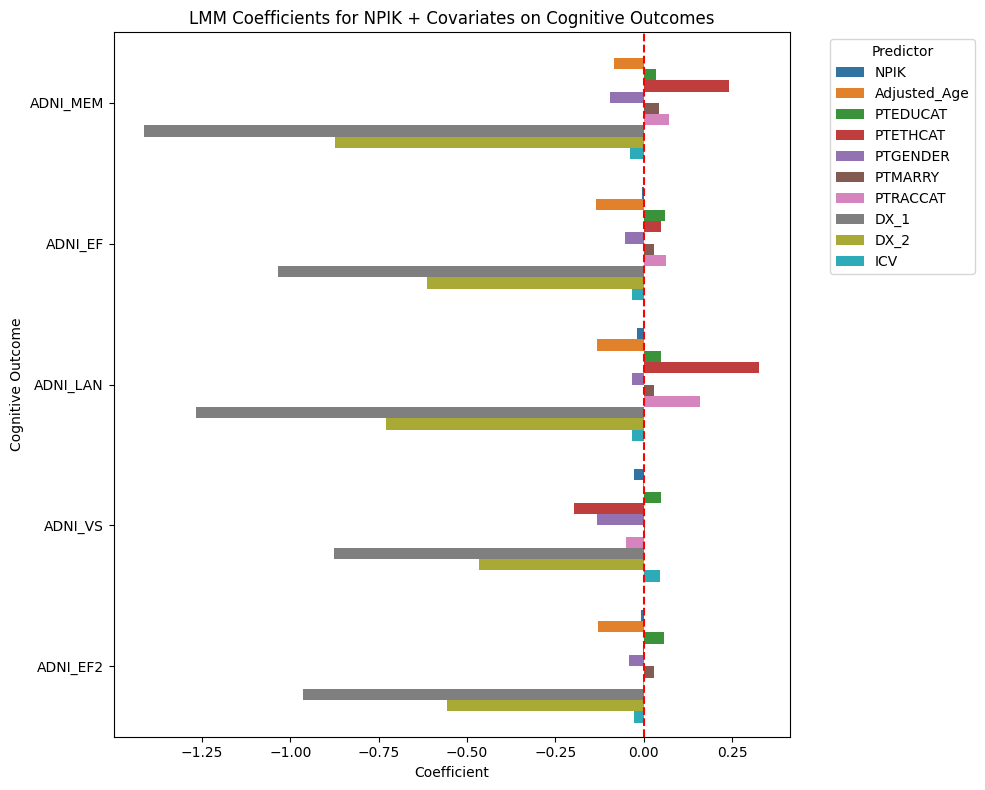

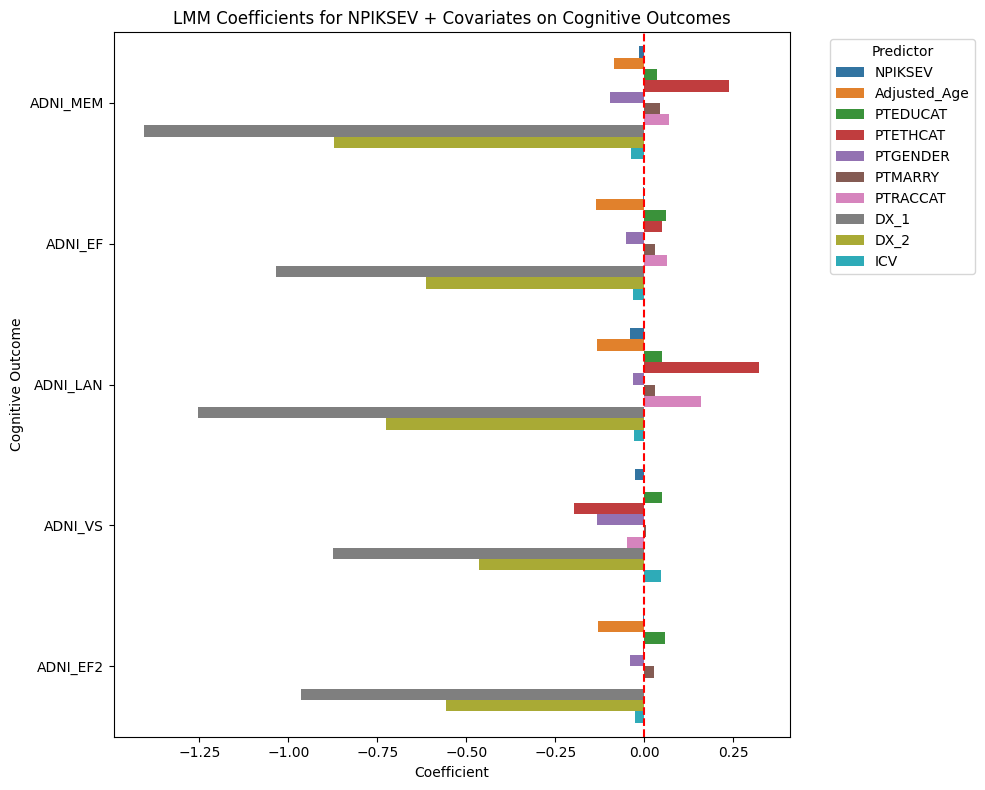

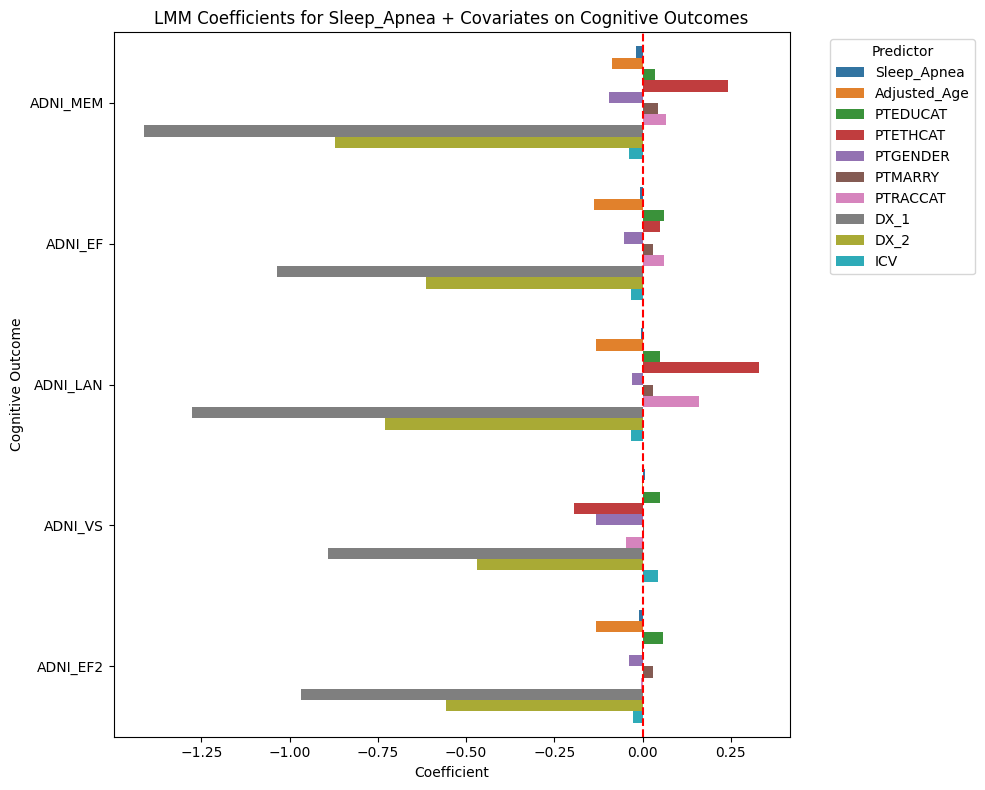

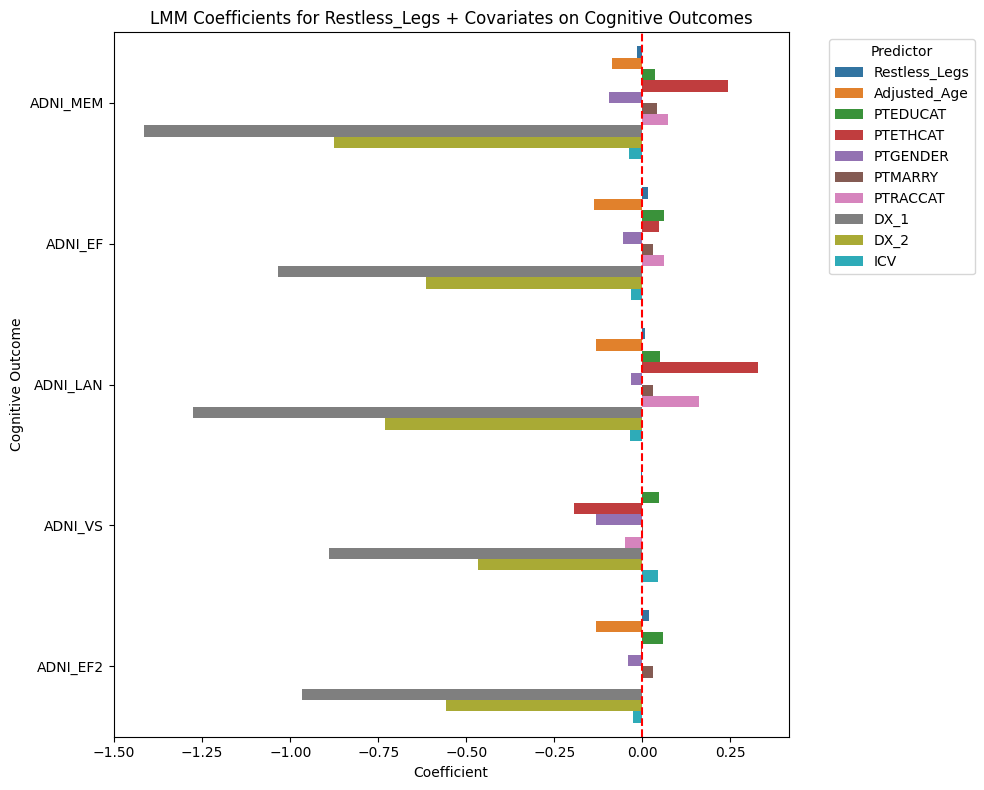

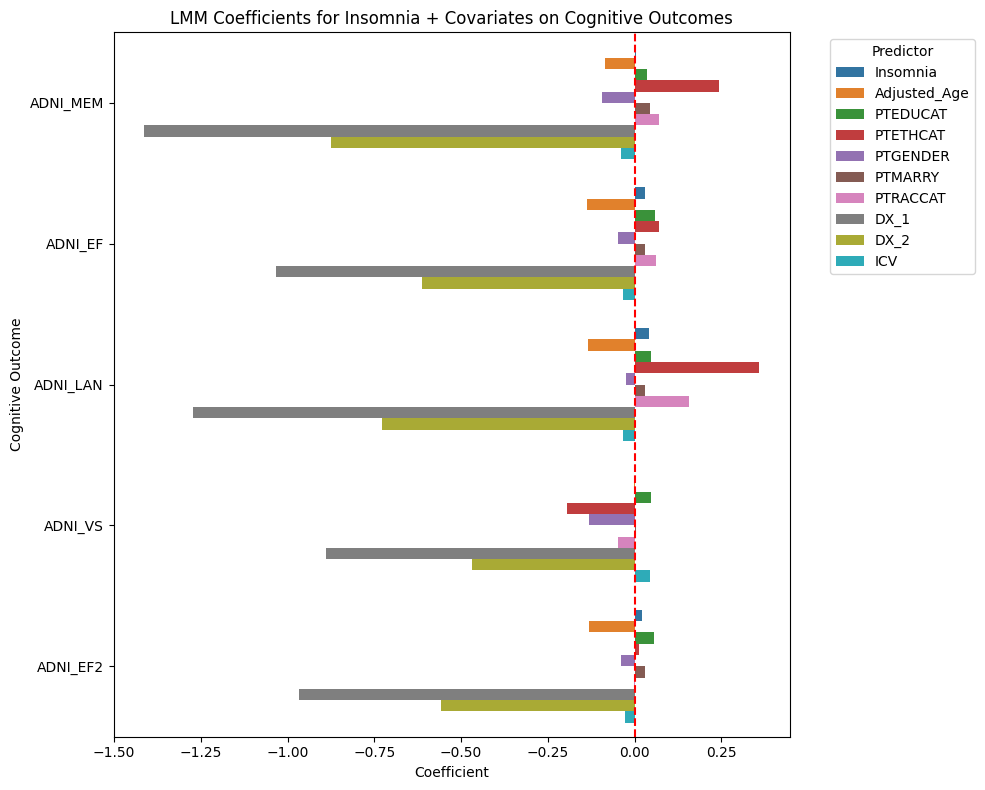

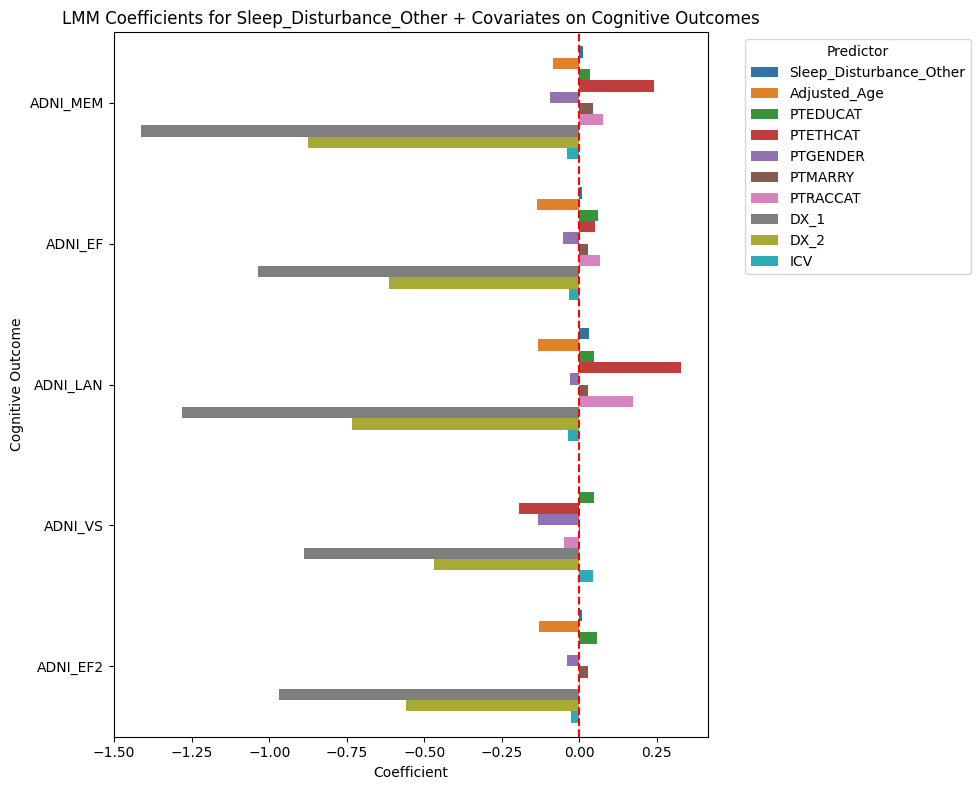

In [81]:
for sleep_var in flat_cog['Sleep_Variable'].unique():
    df_plot = flat_cog[flat_cog['Sleep_Variable'] == sleep_var]

    plt.figure(figsize=(10, 8))
    sns.barplot(
        data=df_plot,
        x='Coefficient',
        y='Outcome',
        hue='Feature',
        dodge=True,
        palette='tab10'
    )

    plt.axvline(x=0, color='red', linestyle='--')
    plt.title(
        f'LMM Coefficients for {sleep_var} + Covariates on Cognitive Outcomes')
    plt.xlabel('Coefficient')
    plt.ylabel('Cognitive Outcome')
    plt.legend(title='Predictor', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

In [83]:
model2_preds = ['APOE4', 'BMI','MH19OTHR',
                'MH2NEURL',
                'MH4CARD',
                'MH5RESP',
                'MHPSYCH',
                ] + model1_preds

In [85]:
sleep_model_results = {
    'cognitive': defaultdict(list),
    'mri': defaultdict(list)
}

model_counter = 1


def store_all_predictors(result, outcome, sleep_var, domain):
    records = []
    for predictor in result.params.index:
        records.append({
            'Model_ID': f"model_{model_counter}",
            'Outcome': outcome,
            'Sleep_Variable': sleep_var,
            'Feature': predictor,
            'Coefficient': result.params.get(predictor, float('nan')),
            'P-Value': result.pvalues.get(predictor, float('nan')),
        })
    return records


for sleep_var in sleep_vars:
    for outcome in cognitive_outcomes:
        try:
            formula = f"{outcome} ~ {sleep_var} + {' + '.join(model2_preds)}"
            model = smf.mixedlm(formula, data=merge_scaled,
                                groups=merge_scaled["RID"])
            result = model.fit(reml=False)

            results = store_all_predictors(
                result, outcome, sleep_var, 'cognitive')
            sleep_model_results['cognitive'][sleep_var].extend(results)
            model_counter += 1
        except Exception as e:
            print(f"[Cognitive] Error for {outcome} with {sleep_var}: {e}")

for sleep_var in sleep_vars:
    for outcome in mri_outcomes:
        try:
            formula = f"{outcome} ~ {sleep_var} + {' + '.join(model2_preds)}"
            model = smf.mixedlm(formula, data=merge_scaled,
                                groups=merge_scaled["RID"])
            result = model.fit(reml=False)

            results = store_all_predictors(result, outcome, sleep_var, 'mri')
            sleep_model_results['mri'][sleep_var].extend(results)
            model_counter += 1
        except Exception as e:
            print(f"[MRI] Error for {outcome} with {sleep_var}: {e}")

In [87]:
import pickle
for sleep_var in sleep_vars:
    with open(f"Models/cognitive_outcomes_{sleep_var}_sd.pkl", 'wb') as f:
        pickle.dump(sleep_model_results['cognitive'][sleep_var], f)

    with open(f"Models/mri_outcomes_{sleep_var}_sd.pkl", 'wb') as f:
        pickle.dump(sleep_model_results['mri'][sleep_var], f)

In [92]:
cog_frames = []
mri_frames = []

for sleep_var in sleep_vars:
    with open(f"Models/cognitive_outcomes_{sleep_var}_sd.pkl", 'rb') as f:
        cognitive_results = pickle.load(f)
        cog_frames.append(pd.DataFrame(cognitive_results))

    with open(f"Models/mri_outcomes_{sleep_var}_sd.pkl", 'rb') as f:
        mri_results = pickle.load(f)
        mri_frames.append(pd.DataFrame(mri_results))

LMM_results_cognitive_df_sd = pd.concat(cog_frames, ignore_index=True)
LMM_results_mri_df_sd = pd.concat(mri_frames, ignore_index=True)

In [93]:
LMM_results_cognitive_df_sd = LMM_results_cognitive_df_sd[~LMM_results_cognitive_df_sd['Feature'].isin( ['Group Var','Intercept'])]
LMM_results_mri_df_sd = LMM_results_mri_df_sd[~LMM_results_mri_df_sd['Feature'].isin( ['Group Var', 'Intercept'])]

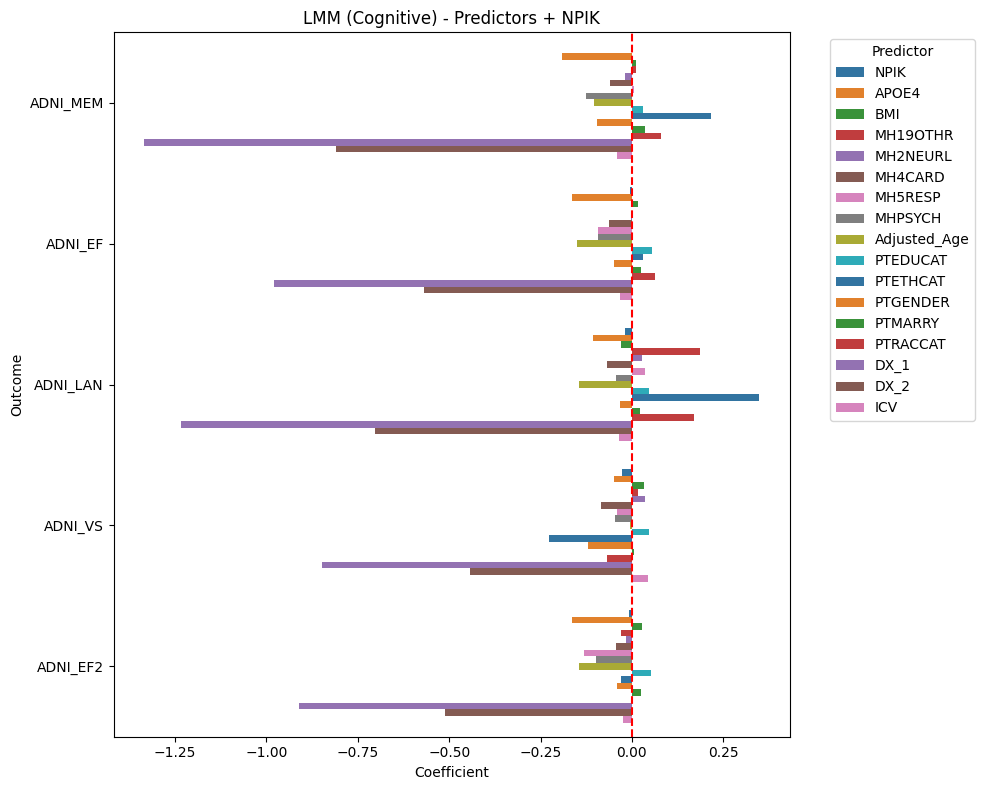

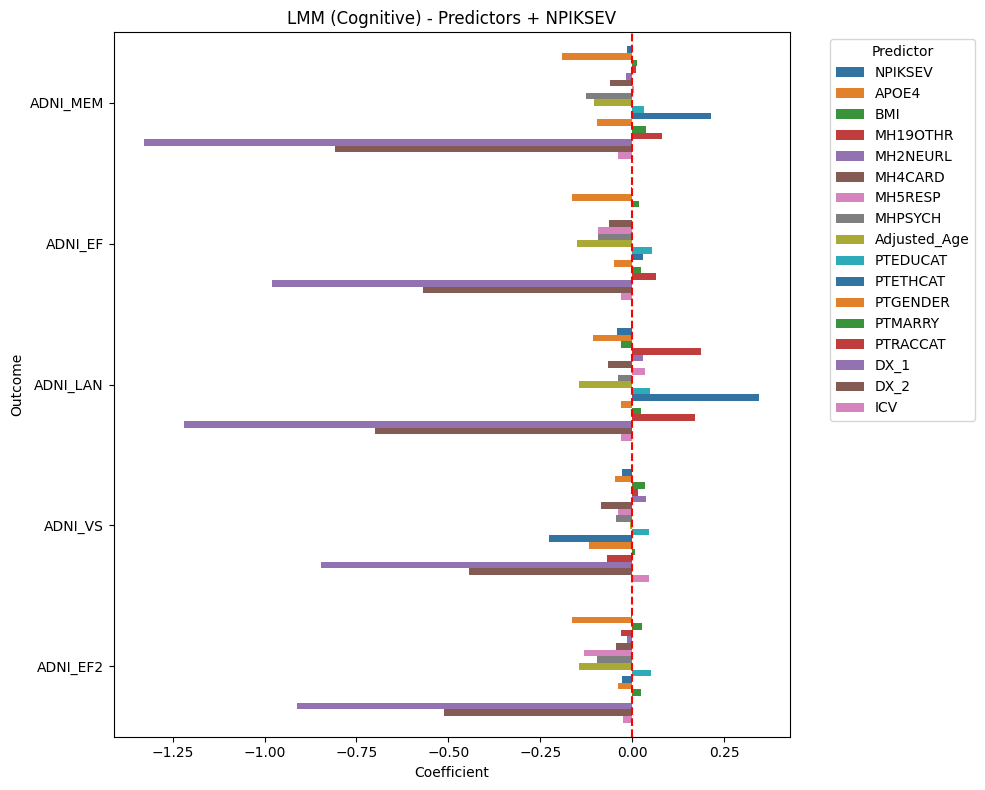

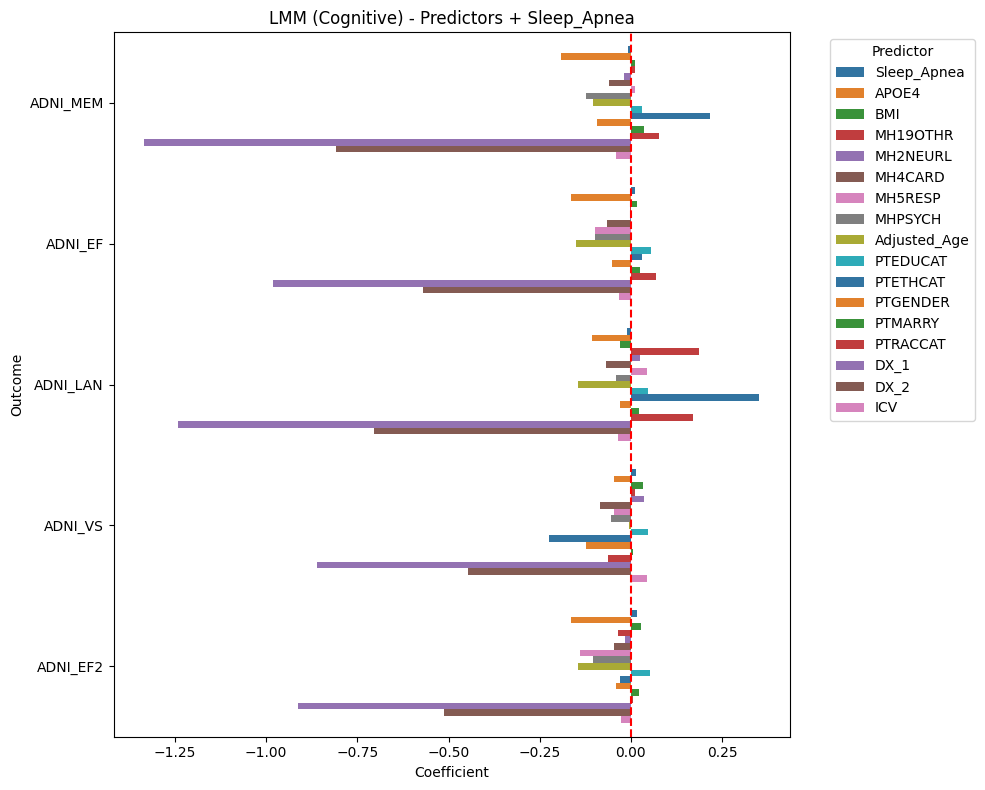

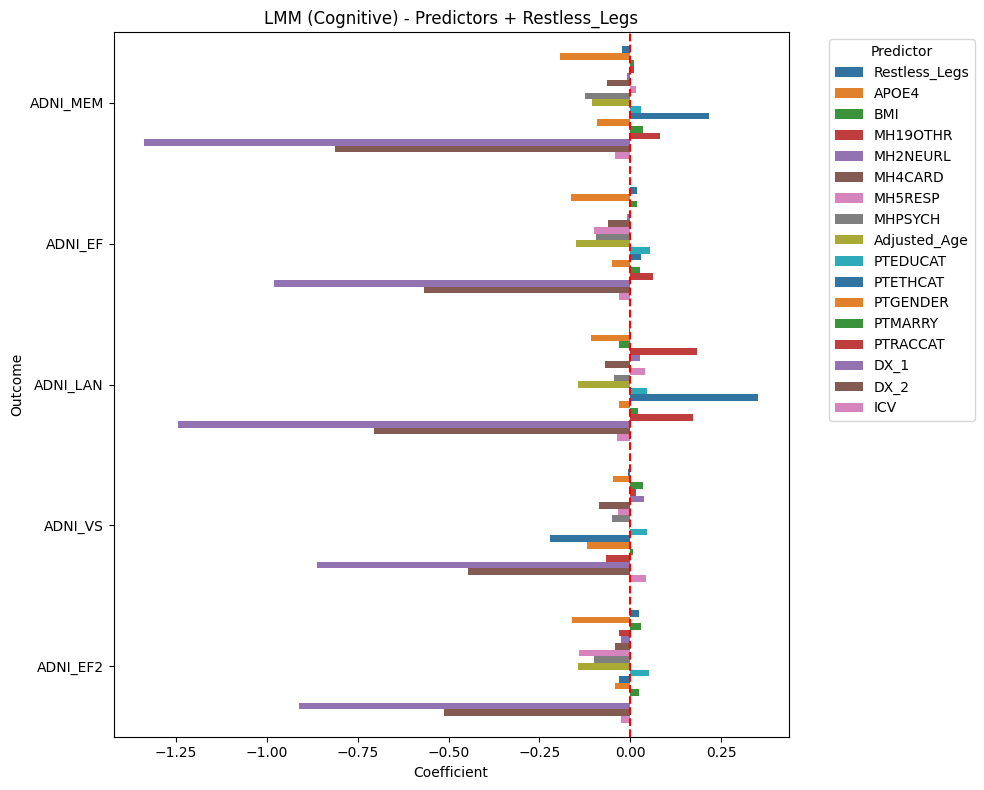

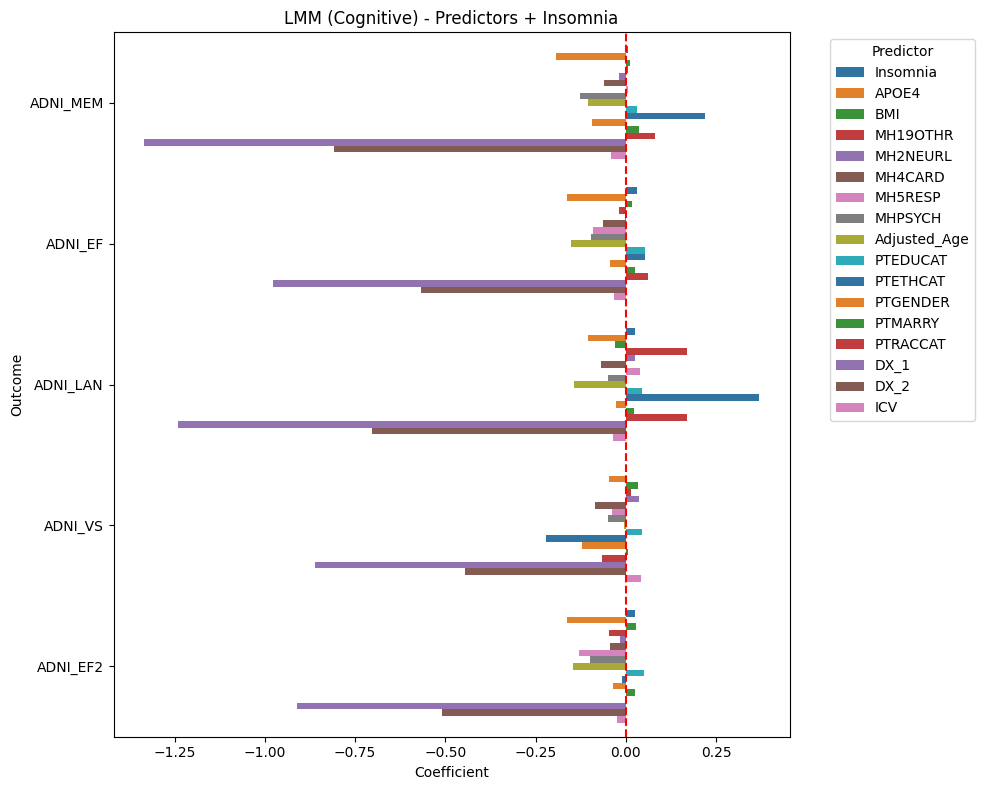

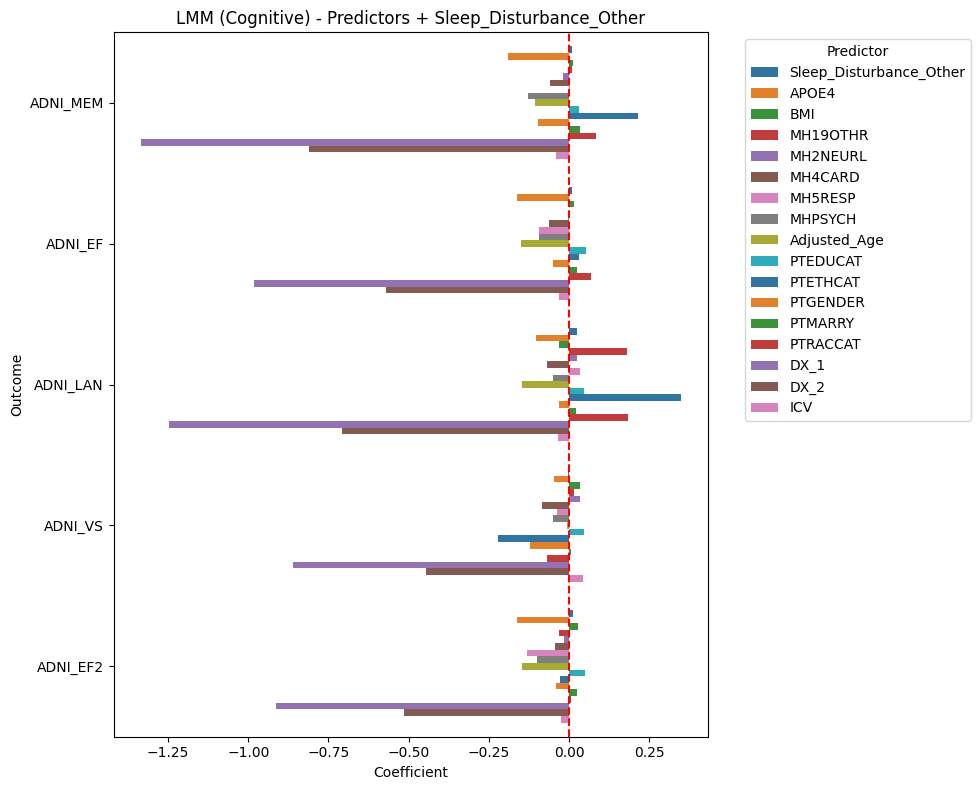

In [94]:
for sleep_var in sleep_vars:
    df_plot = LMM_results_cognitive_df_sd[LMM_results_cognitive_df_sd['Sleep_Variable'] == sleep_var]

    plt.figure(figsize=(10, 8))
    sns.barplot(
        data=df_plot,
        x='Coefficient',
        y='Outcome',
        hue='Feature',
        palette='tab10'
    )
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title(f'LMM (Cognitive) - Predictors + {sleep_var}')
    plt.xlabel('Coefficient')
    plt.ylabel('Outcome')
    plt.legend(title='Predictor', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

In [87]:
DX_bl_ = {0: 'AD', 1: 'CN', 2: 'LMCI'}
DX_ = {0: 'CN', 1: 'Dementia', 2: 'MCI'}
VISCODE_ = {0: 'bl', 1: 'm06', 2: 'm12', 3: 'm24'}

In [88]:
merge['DX_bl_decoded'] = merge['DX_bl'].map(DX_bl_)
merge['DX_decoded'] = merge['DX'].map(DX_)

In [89]:
dx_transitions = []

for rid, group in merge.groupby('RID'):
    dx_seq = group['DX_decoded'].dropna().tolist()
    dx_bl = group['DX_bl_decoded'].iloc[0]

    dx_set = set(dx_seq)

    dx_seq = ['AD' if d == 'Dementia' else d for d in dx_seq]
    dx_set = set(dx_seq)

    if len(dx_set) == 1 and dx_seq[0] == dx_bl:
        dx_status = 'Stable'
    elif dx_bl in ['CN', 'LMCI'] and 'AD' in dx_set:
        dx_status = 'Progressed'
    elif dx_bl == 'AD' and any(x in dx_set for x in ['CN', 'MCI', 'LMCI']):
        dx_status = 'Improved'
    else:
        dx_status = 'Mixed'

    dx_transitions.append({'RID': rid, 'DX_Transition': dx_status})

In [91]:
npiksev_transitions = []

for rid, group in merge.groupby('RID'):
    sev_values = group['NPIKSEV'].dropna().tolist()

    if len(sev_values) <= 1:
        trend = 'Flat'
    else:
        diffs = pd.Series(sev_values).diff().dropna()
        if all(d == 0 for d in diffs):
            trend = 'Flat'
        elif all(d <= 0 for d in diffs) and any(d < 0 for d in diffs):
            trend = 'Improved'
        elif all(d >= 0 for d in diffs) and any(d > 0 for d in diffs):
            trend = 'Worsened'
        else:
            trend = 'Mixed'

    npiksev_transitions.append({'RID': rid, 'NPIKSEV_Trend': trend})

In [94]:
merge['NPIKSEV'].value_counts()

0.0    1759
1.0     213
2.0      95
3.0      21
Name: NPIKSEV, dtype: int64

In [95]:
dx_transition_df = pd.DataFrame(dx_transitions)
npiksev_transition_df = pd.DataFrame(npiksev_transitions)

In [97]:
npiksev_transition_df['NPIKSEV_Trend'].value_counts()

Flat        335
Mixed       101
Worsened     59
Improved     27
Name: NPIKSEV_Trend, dtype: int64

In [98]:
dx_transition_df['DX_Transition'].value_counts()

Stable        273
Mixed         151
Progressed     95
Improved        3
Name: DX_Transition, dtype: int64

In [99]:
transition_summary = pd.merge(
    dx_transition_df, npiksev_transition_df, on='RID')

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

df_long = transition_summary.copy()
df_long = df_long[['DX_Transition', 'NPIKSEV_Trend']]
df_long['Count'] = 1

color_map = {
    'Stable': 'black',
    'Improved': 'green',
    'Progressed': 'red',
    'Mixed': 'blue'
}

df_long['Color'] = df_long['DX_Transition'].map(color_map)

grouped = df_long.groupby(
    ['DX_Transition', 'NPIKSEV_Trend', 'Color']).size().reset_index(name='Count')
fig = go.Figure(data=[
    go.Parcats(
        dimensions=[
            dict(label='Diagnosis Transition',
                 values=grouped['DX_Transition']),
            dict(label='Sleep Severity Trend', values=grouped['NPIKSEV_Trend'])
        ],
        line=dict(
            color=grouped['Color'].apply(lambda c: c),
            colorscale=None
        ),
        counts=grouped['Count']
    )
])

fig.update_layout(
    title='Parallel Categories Plot: Diagnosis vs. Sleep Severity Trends',
    font=dict(size=14)
)

fig.show()

C:\Users\anisr\AppData\Local\Temp\ipykernel_18908\1672972105.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




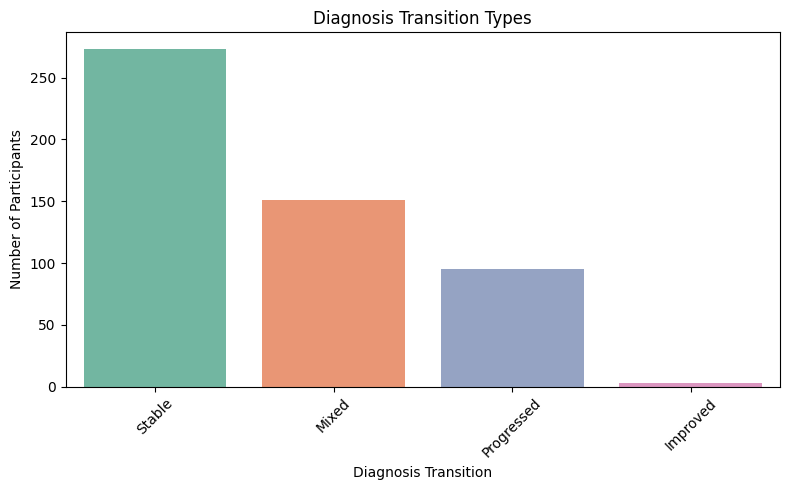

In [106]:
dx_counts = transition_summary['DX_Transition'].value_counts().reset_index()
dx_counts.columns = ['Transition', 'Count']

plt.figure(figsize=(8, 5))
sns.barplot(data=dx_counts, x='Transition', y='Count', palette='Set2')
plt.title('Diagnosis Transition Types')
plt.xlabel('Diagnosis Transition')
plt.ylabel('Number of Participants')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

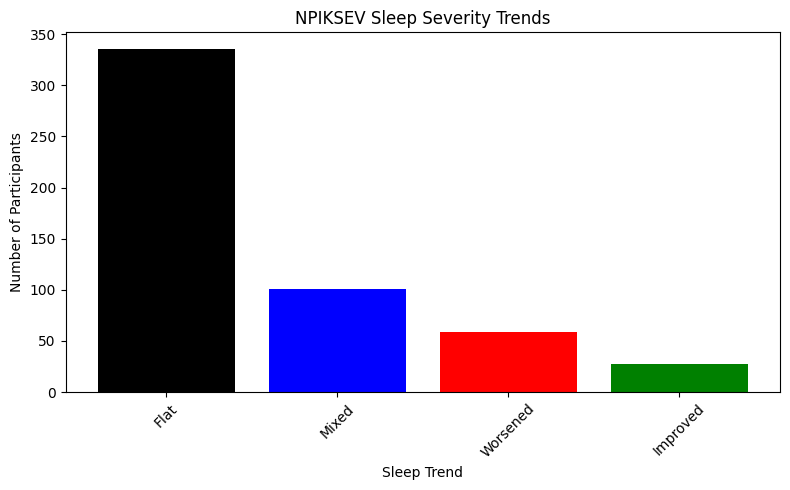

In [110]:
sleep_colors = {
    'Flat': 'black',
    'Improved': 'green',
    'Worsened': 'red',
    'Mixed': 'blue'
}

sleep_counts = transition_summary['NPIKSEV_Trend'].value_counts().reset_index()
sleep_counts.columns = ['Trend', 'Count']
sleep_counts['Color'] = sleep_counts['Trend'].map(sleep_colors)
plt.figure(figsize=(8, 5))
bars = plt.bar(sleep_counts['Trend'],
               sleep_counts['Count'], color=sleep_counts['Color'])
plt.title('NPIKSEV Sleep Severity Trends')
plt.xlabel('Sleep Trend')
plt.ylabel('Number of Participants')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()